# Variational autoencoders 
Acknowledgment: Some pieces of code are taken from this tutorial 
https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

In this tutorial, we will be using Keras to implement a variational autoencoder which will have a number in a given style as an input and the same number in different other styles as an output.

##### Keras
It is an open-source neural-network library written in Python. It is capable of running on top of TensorFlow, Microsoft Cognitive Toolkit, R, Theano, or PlaidML.
Designed to enable fast experimentation with deep neural networks, it focuses on being user-friendly, modular and extensible.

##### libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
import keras as Keras 

from keras.layers import (Input, InputLayer, Dense, Lambda, Layer, Add, Multiply)
from keras.models import Model, Sequential
from keras.datasets import mnist

import pandas as pd

from matplotlib.ticker import FormatStrFormatter
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

import tensorflow as tf

Using TensorFlow backend.


# **Notebook configuration**

In [0]:
np.set_printoptions(precision=2,
                    edgeitems=3,
                    linewidth=80,
                    suppress=True)
#These options determine the way floating point numbers, arrays and other NumPy objects are displayed.

# **Dataset (MNIST)**

In [3]:
#Mnist dataset
# x are the pictures of the digits and y are the labels of digits 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.
#Dimensions 
img_rows, img_cols, img_chns = x_train.shape[1:]

11493376/11490434 [==============================] - 2s 0us/step


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1) / 255.


In [5]:
x_train.shape[1:]

(28, 28, 1)

As seen from the shape of the x_train data, it has 28 rows and 28 columns (28x28 pixels), with each value being kept as an array. **Hence, the data is 784 dimensional**


# **Constant definitions**

In [0]:
# Y in a one-hot vector which gives the class of the digit (from 0 to 9).So it has a dimension of 10.
Y_dim=10
Y_embed_dim = 128
Z_dim=128
#the dimension of the input of the VAE
original_dim = img_rows * img_cols+Y_dim
#the dimension of the intermediate layer 
intermediate_dim = 256
#the dimension of the latent variable (Z+Y)
latent_dim = Y_dim+Z_dim
#training constants
batch_size = 100
epochs = 50
epsilon_std = 1.0

# **Negative log likelihood (Bernoulli)**
## This first term is the **reconstruction loss** (the negative log likelihood of the *i*-th data point)

In [0]:
def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

# **KL-Divergence**

In [0]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs


# **The Re-parametrization trick**

## The re-parametrization trick allows us to include the randomness of a normally distributed random variable *Z* into epsilon, where ϵ ~ *N(0,1)*:


```
Z= μ + σ.ϵ
```



The encoder q(z|x) is a neural network that encodes the 784 dimensional data into a latent representaion space Z which is 128 dimensional.

The decoder p(x|z) is a neural network takes in the input of representation *z* and outputs 784 bernoulli parameters (one for each pixel in the image). 



In [0]:
#Encoder
#Inference network
x = Input(shape=(original_dim,),name='x') # Shape = 784+10
h = Dense(intermediate_dim, activation='relu',name='hidden_layer_encoder')(x)

z_mu = Dense(Z_dim, name='mu')(h)
z_log_var = Dense(Z_dim, name='log_var')(h)

z_mu, z_log_var = KLDivergenceLayer(name='KLDivergence')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

# Reparameterization with Merge Layers
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          Z_dim)), name='epsilon')

z_eps = Multiply(name='z_eps')([z_sigma, eps])
Z = Add(name='z')([z_mu, z_eps])
Y=Input(tensor=tf.slice(x,[0,0],[-1,Y_dim]), name='Y')
zy=Keras.layers.Concatenate(name='z_Y')([Z, Y])

#Decoder
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu', name='hidden_dec'),
    Dense(original_dim, activation='sigmoid', name='x_pred')
], name='decoder')

#Output
x_pred = decoder(zy)


# **Specifying the VAE**

In [0]:
vae = Model(inputs=[x, eps ,Y], outputs=x_pred, name='vae')
vae.compile(optimizer='rmsprop', loss=nll)

# **Simplified architecture visualization**

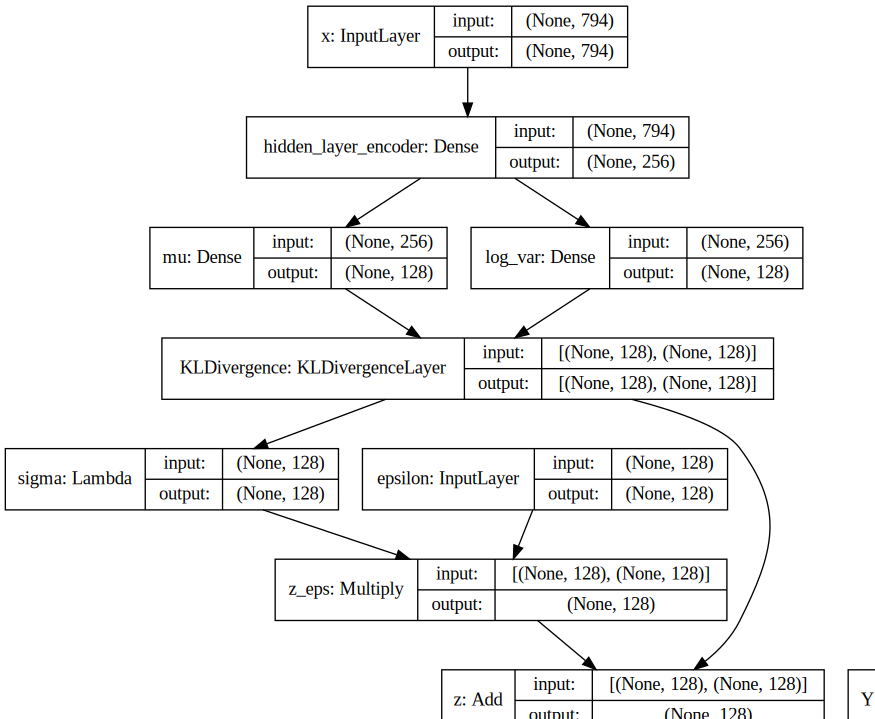

In [20]:
import pydotplus
import pydot
from keras.utils.vis_utils import model_to_dot
import keras
keras.utils.vis_utils.pydot = pydot

SVG(model_to_dot(vae, show_shapes=True)
    .create(prog='dot', format='svg'))


# **Model fitting**

In [0]:
#Data extraction
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim-10) / 255. # NORMALIZATION
x_test = x_test.reshape(-1, original_dim-10) / 255.
#creating one-hot vector for each digit
Y_train=np.zeros((60000,10))


for i in range(60000):
    Y_train[i,y_train[i]]=1

Y_test=np.zeros((10000,10))
for i in range(10000):
    Y_test[i,y_test[i]]=1
    
#Concatinationg the pixels of the digit with Y the one-hot vector representing the Class of the digit 
x_train=np.concatenate((Y_train,x_train),axis=1)
x_test=np.concatenate((Y_test,x_test),axis=1)


In [44]:
x_train.shape[:]

(60000, 794)

In [45]:
Y_train.shape[:]

(60000, 10)

In [24]:
#Training the VAE
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test,x_test)
)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 9s 155us/step - loss: 164.6780 - val_loss: 140.1856
Epoch 2/50
60000/60000 [==============================] - 9s 148us/step - loss: 133.8191 - val_loss: 127.7965
Epoch 3/50
60000/60000 [==============================] - 9s 150us/step - loss: 123.5853 - val_loss: 118.9121
Epoch 4/50
60000/60000 [==============================] - 9s 150us/step - loss: 117.0416 - val_loss: 113.6606
Epoch 5/50
60000/60000 [==============================] - 9s 151us/step - loss: 112.9421 - val_loss: 111.0126
Epoch 6/50
60000/60000 [==============================] - 9s 150us/step - loss: 110.2710 - val_loss: 108.3041
Epoch 7/50
60000/60000 [==============================] - 9s 149us/step - loss: 108.4764 - val_loss: 107.4796
Epoch 8/50
60000/60000 [==============================] - 9s 148us/step - loss: 107.2865 - val_loss: 105.8047
Epoch 9/50
60000/60000 [==============================] - 9s 148us/ste

# **Model Evaluation**

Training a model means minimizing a loss function. However, in variational inference, we maximize the ELBO (which is not a loss function). Hence, this leads to awkwardness where we minimize the the **NEGATIVE** ELBO, as optimizers in nerual networks only support minimization.

In [0]:
%matplotlib inline

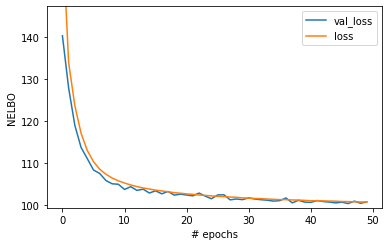

In [41]:
golden_size = lambda width: (width, 2. * width / (1 + np.sqrt(5)))
#NELBO
fig, ax = plt.subplots(figsize=golden_size(6))

hist_df = pd.DataFrame(hist.history)
hist_df.plot(ax=ax)

ax.set_ylabel('NELBO')
ax.set_xlabel('# epochs')

ax.set_ylim(.99*hist_df[1:].values.min(), 
            1.1*hist_df[1:].values.max())


plt.show()